# Capstone Project - Exploring Restaurants in Lisbon (Week 2)
### Applied Data Science Capstone by IBM/Coursera

Gustavo Bakker

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

Lisbon is the capital and the largest city of Portugal, with it’s population of about 500 thousand people living in the main area and about 2.8 million people in the metropolitan area, is the 10th most populous urban area of the European union. The city has not only native portuguese people but a lot of emigrant people coming from around the world, being a multicultural city that offers different kinds of events, restaurants, shops, concerts, museums,etc.

There are tons of restaurants in Lisbon and they are of different kinds and from different cultures. In this project we will see how **types of restaurants** and their food will vary in different neighbourhoods, with the goal of giving understanding of how this can **help stakeholders by giving information about catergories of restaurants that we can find in each neighbourhood of Lisbon**.

We will try to take advantage of techniques such as *Exploratory Data Analysis (EDA)* and *Machine Learning* algorithms to cluster this neighbourhoods using the unsupervised learning algorithm K-Means.

## Data <a name="data"></a>

We will study factors that are relevant for the understanding of the types of restaurant in Lisbon such as the variety of foods and culture and the amount of restaurants per zone.

We will use the following resources to get our data:

**Lisbon City Neighbourhoods Dataset**
Source: https://pt.wikipedia.org/wiki/Lista_de_freguesias_de_Lisboa.
This is a table from Wikipedia (portuguese version), that has all the 24 neighbourhoods of Lisbon city, containing information about the population and area for each one.

**Foursquare API**
Source: https://developer.foursquare.com/docs 
This is a location data provider consisting of a RESTful API that allows to retrieve information of venues of a certain neighbourhood using coordinates, giving us a rich JSON file with details about restaurants and their locations, provided by the neighbourhoods dataset of Lisbon.


In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## 1. Download and Explore Dataset

In [2]:
tables = pd.read_html('https://pt.wikipedia.org/wiki/Lista_de_freguesias_de_Lisboa')

In [3]:
# show dataframe
df = tables[0]
df.head()

Freguesias atuais                                                \
        N.º[nota 1]    Brasão    Freguesia (Zona)[1] População[4]   
0                 1       NaN      Ajuda (Ocidental)       15 617   
1                 2       NaN  Alcântara (Ocidental)       13 943   
2                54  [nota 6]      Alvalade (Centro)       31 813   
3                54  [nota 6]      Alvalade (Centro)       31 813   
4                54  [nota 6]      Alvalade (Centro)       31 813   

                Freguesias antigas         \
   Área(km²)[3]        N.º[nota 2] Brasão   
0           288                  1    NaN   
1  5,07[nota 4]                  2    NaN   
2           534                  4    NaN   
3           534                  9    NaN   
4           534                 42    NaN   

                                                                           
                       Freguesia (Bairro) População(2011)[6] Área(km²)[5]  
0              Ajuda[nota 3] (2.º Bairro)             15 584          286  
1          Alcântara[nota 5] (2.º Bairro)             13 943          444  
2           Alvalade[nota 7] (3.º Bairro)              8 869           60  
3       Campo Grande[nota 8] (3.º Bairro)             10 514          245  
4  São João de Brito[nota 9] (3.º Bairro)             11 727          223

**Let's clean a little bit our dataset**

This table from Wikipedia is originally a bit confusing for our study, so we need to clean it up.

In [4]:
# drop unecessary columns
df = df.drop(['Freguesias antigas'], axis=1)
df = df.drop(('Freguesias atuais', 'Brasão'), axis=1)
df = df.drop(('Freguesias atuais', 'N.º[nota 1]'), axis=1)

# rename columns to simples names
df = df.rename(columns={'Freguesia (Zona)[1]': 'Neighbourhood', 'População[4]': 'Population', 'Área(km²)[3]': 'Area'})

# drop level 0 unecessary column
df.columns = df.columns.droplevel(0)

# sorting by first name and remove duplicates
df.sort_values("Neighbourhood", inplace = True)
df.drop_duplicates(keep = 'first', inplace = True)

# remove extra white spaces and all brackets with text inside with some regex
df['Neighbourhood'] = df['Neighbourhood'].str.replace(r"\(.*\)","")
df['Neighbourhood'] = df['Neighbourhood'].str.replace(r"\[.*\]","")
df['Neighbourhood'] = df['Neighbourhood'].str.rstrip(' ')
df['Neighbourhood'] = df['Neighbourhood'].str.lstrip(' ')
df['Area'] = df['Area'].str.replace(r"\(.*\)","")
df['Area'] = df['Area'].str.replace(r"\[.*\]","")
df.head(20)

/Users/gustavobakker/opt/anaconda3/envs/deeplearning/lib/python3.7/site-packages/pandas/core/generic.py:3935: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


,Neighbourhood,Population,Area
0,Ajuda,15 617,288
1,Alcântara,13 943,"5,07"
2,Alvalade,31 813,534
5,Areeiro,20 131,174
7,Arroios,31 653,213
10,Avenidas Novas,21 625,299
12,Beato,12 737,"2,46"
14,Belém,16 528,"10,43"
15,Benfica,36 985,803
16,Campo de Ourique,22 120,165


**Now that the table looks clean and nice, let's get the coordinates for each Neighbourhood and append them to our current dataframe**

In [5]:
# !pip install geopy
from geopy.geocoders import Nominatim

latitudes = []
longitudes = []
geolocator = Nominatim(user_agent="foursquare_agent")
for i in df['Neighbourhood']:
    location = geolocator.geocode(i+', Lisboa')
    latitudes.append(location.latitude)
    longitudes.append(location.longitude)
    
df['Latitude'] = latitudes
df['Longitude'] = longitudes

**Now we should create a map of the Lisbon main area**

In [6]:
# create map of Lisbon using latitude and longitude values
address = 'Lisbon, Portugal'
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
map_lisbon = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for municipality, lat, lng in zip(df['Neighbourhood'], df['Latitude'], df['Longitude']):
    label = municipality
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_lisbon)  
    
map_lisbon

### Foursquare API
Let's use Foursquare API to retrieve information of restaurants in each neighborhood.

We're interested in venues in 'food' category, but only those that are proper restaurants - coffe shops, pizza places, bakeries etc. are not direct competitors so we don't care about those. So we will include in out list only venues that have 'restaurant' in category name.

Let's define Foursquare Credentials and Version

In [7]:
CLIENT_ID = 'YVPILMROKD5UBPK2FPEADJGMUMLG35NJ1FRKPRZ3PMSF5151' # your Foursquare ID
CLIENT_SECRET = 'TZAWSEC1LGA3JURHERCGGPQYBK0I5ABK5LKKNE1MK5EINWUV' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: YVPILMROKD5UBPK2FPEADJGMUMLG35NJ1FRKPRZ3PMSF5151
CLIENT_SECRET:TZAWSEC1LGA3JURHERCGGPQYBK0I5ABK5LKKNE1MK5EINWUV


**Fetch Foursquare Venue Category Hierarchy**

In [8]:
url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION)
category_results = requests.get(url).json()

In [9]:
for key, value in category_results['response']['categories'][0].items():
    print(key, len(str(value)))

id 24
name 20
pluralName 20
shortName 20
icon 98
categories 15910


In [10]:
category_list = category_results['response']['categories']

In [11]:
for data in category_list:
    print(data['id'], data['name'])

4d4b7104d754a06370d81259 Arts & Entertainment
4d4b7105d754a06372d81259 College & University
4d4b7105d754a06373d81259 Event
4d4b7105d754a06374d81259 Food
4d4b7105d754a06376d81259 Nightlife Spot
4d4b7105d754a06377d81259 Outdoors & Recreation
4d4b7105d754a06375d81259 Professional & Other Places
4e67e38e036454776db1fb3a Residence
4d4b7105d754a06378d81259 Shop & Service
4d4b7105d754a06379d81259 Travel & Transport


**Category 'Food' and subcategories**


In [12]:
def flatten_Hierarchy(category_list, checkParentID, category_dict, parent_id = ''):
    for data in category_list:
        
        if checkParentID == True and data['id'] == parent_id:
            category_dict[data['id']] = data['name']
            flatten_Hierarchy(category_list = data['categories'], checkParentID = False, category_dict = category_dict)
        
        elif checkParentID == False:
            category_dict[data['id']] = data['name']
            if len(data['categories']) != 0:
                flatten_Hierarchy(category_list = data['categories'], checkParentID = False, category_dict = category_dict)
    
    return category_dict

In [13]:
# 'name' and 'id' of all subcategories
category_dict = flatten_Hierarchy(category_list, checkParentID=True, category_dict = {}, parent_id = '4d4b7105d754a06375d81259')

### Let's have a look of the restaurants of a specific neighbourhood
#### In this example we will choose the neighbourhood 'Alvalade'

In [14]:
alvalade_data = df[df['Neighbourhood'] == 'Alvalade'].reset_index(drop=True)
alvalade_data.head()

,Neighbourhood,Population,Area,Latitude,Longitude
0,Alvalade,31 813,534,38.753341,-9.14914


In [15]:
alvalade_latitude = alvalade_data.loc[0, 'Latitude'] # alvalade latitude value
alvalade_longitude = alvalade_data.loc[0, 'Longitude'] # alvalade longitude value

alvalade_name = alvalade_data.loc[0, 'Neighbourhood'] # alvalade name

print('Latitude and longitude values of {} are {}, {}.'.format(alvalade_name, 
                                                               alvalade_latitude, 
                                                               alvalade_longitude))

Latitude and longitude values of Alvalade are 38.753340800000004, -9.149139808585797.


In [16]:
LIMIT = 1 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
categoryId = '4d4b7105d754a06374d81259' # category ID for "Food"

# create URL

url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    alvalade_latitude, 
    alvalade_longitude, 
    radius,
    categoryId,
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/search?&client_id=YVPILMROKD5UBPK2FPEADJGMUMLG35NJ1FRKPRZ3PMSF5151&client_secret=TZAWSEC1LGA3JURHERCGGPQYBK0I5ABK5LKKNE1MK5EINWUV&v=20180605&ll=38.753340800000004,-9.149139808585797&radius=500&categoryId=4d4b7105d754a06374d81259&limit=1'

In [17]:
results = requests.get(url).json()

In [18]:
# JSON output
results['response']['venues']

[{'id': '5ae3137cc66666002c4a9e7e',
  'name': 'Soão - Taberna Asiática',
  'location': {'address': 'Avenida de Roma, 100',
   'lat': 38.754227,
   'lng': -9.144887,
   'labeledLatLngs': [{'label': 'display',
     'lat': 38.754227,
     'lng': -9.144887}],
   'distance': 382,
   'postalCode': '1700-352',
   'cc': 'PT',
   'city': 'Lisboa',
   'state': 'Lisboa',
   'country': 'Portugal',
   'formattedAddress': ['Avenida de Roma, 100',
    '1700-352 Lisboa',
    'Portugal']},
  'categories': [{'id': '4bf58dd8d48988d142941735',
    'name': 'Asian Restaurant',
    'pluralName': 'Asian Restaurants',
    'shortName': 'Asian',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_',
     'suffix': '.png'},
    'primary': True}],
  'referralId': 'v-1581650614',
  'hasPerk': False}]

The _categoryId_ parameter in the API request URL can be a comma seperated string. So, lets create a comma seperated string from _category_\__dict_.

In [19]:
categoryId_list = []
for key, value in category_dict.items():
    categoryId_list.append(key)
categoryId = ','.join(categoryId_list)

### Exploring restaurants in the area
#### Let's create a function to repeat the same process to all the neighbourhoods in Lisbon

In [20]:
def getNearbyRestaurants(names, latitudes, longitudes, radius=1000, LIMIT=500):
    not_found = 0
    print('***Start ', end='')
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(' .', end='')
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            "4d4b7105d754a06374d81259", # 'Food' category ID
            LIMIT)
            
        try:
            # make the GET request
            results = requests.get(url).json()['response']['venues']
            
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['name'], 
                v['location']['lat'], 
                v['location']['lng'],  
                v['categories'][0]['name']) for v in results])
        except:
            not_found += 1


    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    return(nearby_venues)

In [21]:
lisbon_restaurants = getNearbyRestaurants(names=df['Neighbourhood'],
                                        latitudes=df['Latitude'],
                                        longitudes=df['Longitude'])

***Start  . . . . . . . . . . . . . . . . . . . . . . . .

**Let's show all the restaurants for each neighbourhood by filtering the column 'Venue Category' that contains the word 'Restaurant'**

In [22]:
lisbon_restaurants = lisbon_restaurants.loc[lisbon_restaurants['Venue Category'].str.contains("Restaurant")]
lisbon_restaurants.head(10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Ajuda,38.712327,-9.201241,Mercado do Peixe,38.712692,-9.203276,Seafood Restaurant
2,Ajuda,38.712327,-9.201241,Mestrias,38.704125,-9.200251,Portuguese Restaurant
4,Ajuda,38.712327,-9.201241,Pátio Da Memória,38.703976,-9.202342,Portuguese Restaurant
5,Ajuda,38.712327,-9.201241,bitoque no ponto,38.703402,-9.207821,Portuguese Restaurant
6,Ajuda,38.712327,-9.201241,Fateixa Restaurante,38.705097,-9.206943,Restaurant
7,Ajuda,38.712327,-9.201241,1400 Restelo,38.706326,-9.207668,Portuguese Restaurant
10,Ajuda,38.712327,-9.201241,Restaurante O CIF,38.714074,-9.210142,Portuguese Restaurant
13,Ajuda,38.712327,-9.201241,Restaurante Andorinhas,38.704911,-9.199349,Restaurant
14,Ajuda,38.712327,-9.201241,Gandhi Palace,38.711753,-9.213402,Indian Restaurant
15,Ajuda,38.712327,-9.201241,Chang Feng,38.706323,-9.209046,Chinese Restaurant


## Methodology <a name="methodology"></a>

We are filtering all venues by showing only the restaurant categories so we can see all the restaurants for each neighbourhood.

Using _geopy_ library we could retrieve a coordinates like latitude and longitude for each of the neighbourhoods, so then we can use the Foursquare API to use those coordinates to get the locals of interest for that area of the map, in a JSON file that contains all the details.

Then it is created a dataframe with Neighborhood, Latitude and Longitude details of the Lisbon’s neighborhoods.

We used a technique of filtering this dataframe by the venue categories that contain the word 'Restaurant', so instead of generalization for food we're only filtering the restaurants.

## Analysis <a name="analysis"></a>

#### Let's analyse the different kinds of restaurants and their quantity in Lisbon

In [23]:
print('There are {} uniques categories.'.format(len(lisbon_restaurants['Venue Category'].unique())))
lisbon_restaurants.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False)

There are 34 uniques categories.


Venue Category
Portuguese Restaurant            182
Restaurant                       115
Italian Restaurant                32
Fast Food Restaurant              24
Seafood Restaurant                20
Sushi Restaurant                  18
Chinese Restaurant                17
Tapas Restaurant                  15
Indian Restaurant                 14
Mediterranean Restaurant          12
Asian Restaurant                  11
Japanese Restaurant               10
Vegetarian / Vegan Restaurant     10
African Restaurant                 8
Brazilian Restaurant               7
Ramen Restaurant                   6
Comfort Food Restaurant            6
Mexican Restaurant                 4
American Restaurant                4
Dim Sum Restaurant                 3
Middle Eastern Restaurant          3
Persian Restaurant                 2
Argentinian Restaurant             2
Peruvian Restaurant                2
Spanish Restaurant                 2
Himalayan Restaurant               2
Thai Restaurant        

### Analyze Each Neighborhood

In [24]:
# one hot encoding
lisbon_restaurants_onehot = pd.get_dummies(lisbon_restaurants[['Venue Category']], prefix="", prefix_sep="")
lisbon_restaurants_onehot.head()

,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Brazilian Restaurant,Cantonese Restaurant,Chinese Restaurant,Comfort Food Restaurant,Dim Sum Restaurant,Fast Food Restaurant,Gluten-free Restaurant,Himalayan Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Lebanese Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Persian Restaurant,Peruvian Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,Spanish Restaurant,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [25]:
# add neighborhood to one_hot dataframe
lisbon_restaurants_onehot['Neighborhood'] = lisbon_restaurants['Neighborhood']

# and put it to first column
Neighborhood = lisbon_restaurants_onehot['Neighborhood']
lisbon_restaurants_onehot.drop(labels=['Neighborhood'], axis=1,inplace = True)
lisbon_restaurants_onehot.insert(0, 'Neighborhood', Neighborhood)

lisbon_restaurants_onehot.head()

,Neighborhood,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Brazilian Restaurant,Cantonese Restaurant,Chinese Restaurant,Comfort Food Restaurant,Dim Sum Restaurant,Fast Food Restaurant,Gluten-free Restaurant,Himalayan Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Lebanese Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Persian Restaurant,Peruvian Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,Spanish Restaurant,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Ajuda,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,Ajuda,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,Ajuda,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Ajuda,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
6,Ajuda,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [26]:
lisbon_restaurants_onehot.shape

(541, 35)

In [27]:
restaurants_counts = lisbon_restaurants_onehot.groupby('Neighborhood').sum()
restaurants_counts.head(5)

,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Brazilian Restaurant,Cantonese Restaurant,Chinese Restaurant,Comfort Food Restaurant,Dim Sum Restaurant,Fast Food Restaurant,Gluten-free Restaurant,Himalayan Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Lebanese Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Persian Restaurant,Peruvian Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,Spanish Restaurant,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
Neighborhood,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ajuda,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,9,0,7,1,0,0,1,0,0,0,0
Alcântara,0,0,0,0,1,0,0,0,0,1,1,0,0,2,0,0,0,3,1,0,1,0,0,8,0,8,1,1,0,0,0,0,0,0
Alvalade,0,0,0,1,1,0,2,0,0,3,0,0,0,3,1,0,0,2,0,0,0,1,0,8,0,3,0,0,3,1,1,0,0,0
Areeiro,1,0,0,1,2,0,2,0,0,2,0,0,0,2,0,0,0,0,0,1,0,1,0,6,0,2,0,0,1,1,0,0,1,0
Arroios,0,0,0,1,0,0,2,0,0,2,0,0,1,3,1,0,0,0,0,0,0,0,0,6,1,1,1,0,0,1,1,0,1,0


In [28]:
restaurants_counts_described = restaurants_counts.describe().transpose()
restaurant_top10 = restaurants_counts_described.sort_values('max', ascending=False)[0:10]
restaurant_top10

,count,mean,std,min,25%,50%,75%,max
Portuguese Restaurant,24.0,7.583333,2.701315,4.0,5.75,7.0,9.25,13.0
Restaurant,24.0,4.791667,3.134370,1.0,2.00,4.0,6.25,12.0
Italian Restaurant,24.0,1.333333,1.307725,0.0,0.00,1.5,2.00,4.0
Mediterranean Restaurant,24.0,0.500000,0.884652,0.0,0.00,0.0,1.00,3.0
Tapas Restaurant,24.0,0.625000,0.710939,0.0,0.00,1.0,1.00,3.0
Sushi Restaurant,24.0,0.750000,1.073394,0.0,0.00,0.0,1.00,3.0
Seafood Restaurant,24.0,0.833333,0.868115,0.0,0.00,1.0,1.00,3.0
Fast Food Restaurant,24.0,1.000000,0.834058,0.0,0.00,1.0,1.25,3.0
Indian Restaurant,24.0,0.583333,0.717282,0.0,0.00,0.0,1.00,2.0
Vegetarian / Vegan Restaurant,24.0,0.416667,0.583592,0.0,0.00,0.0,1.00,2.0


#### We can use _seaborn_ library to visualize some good looking graphs

In [29]:
restaurant_top10_list = restaurant_top10.index.values.tolist()

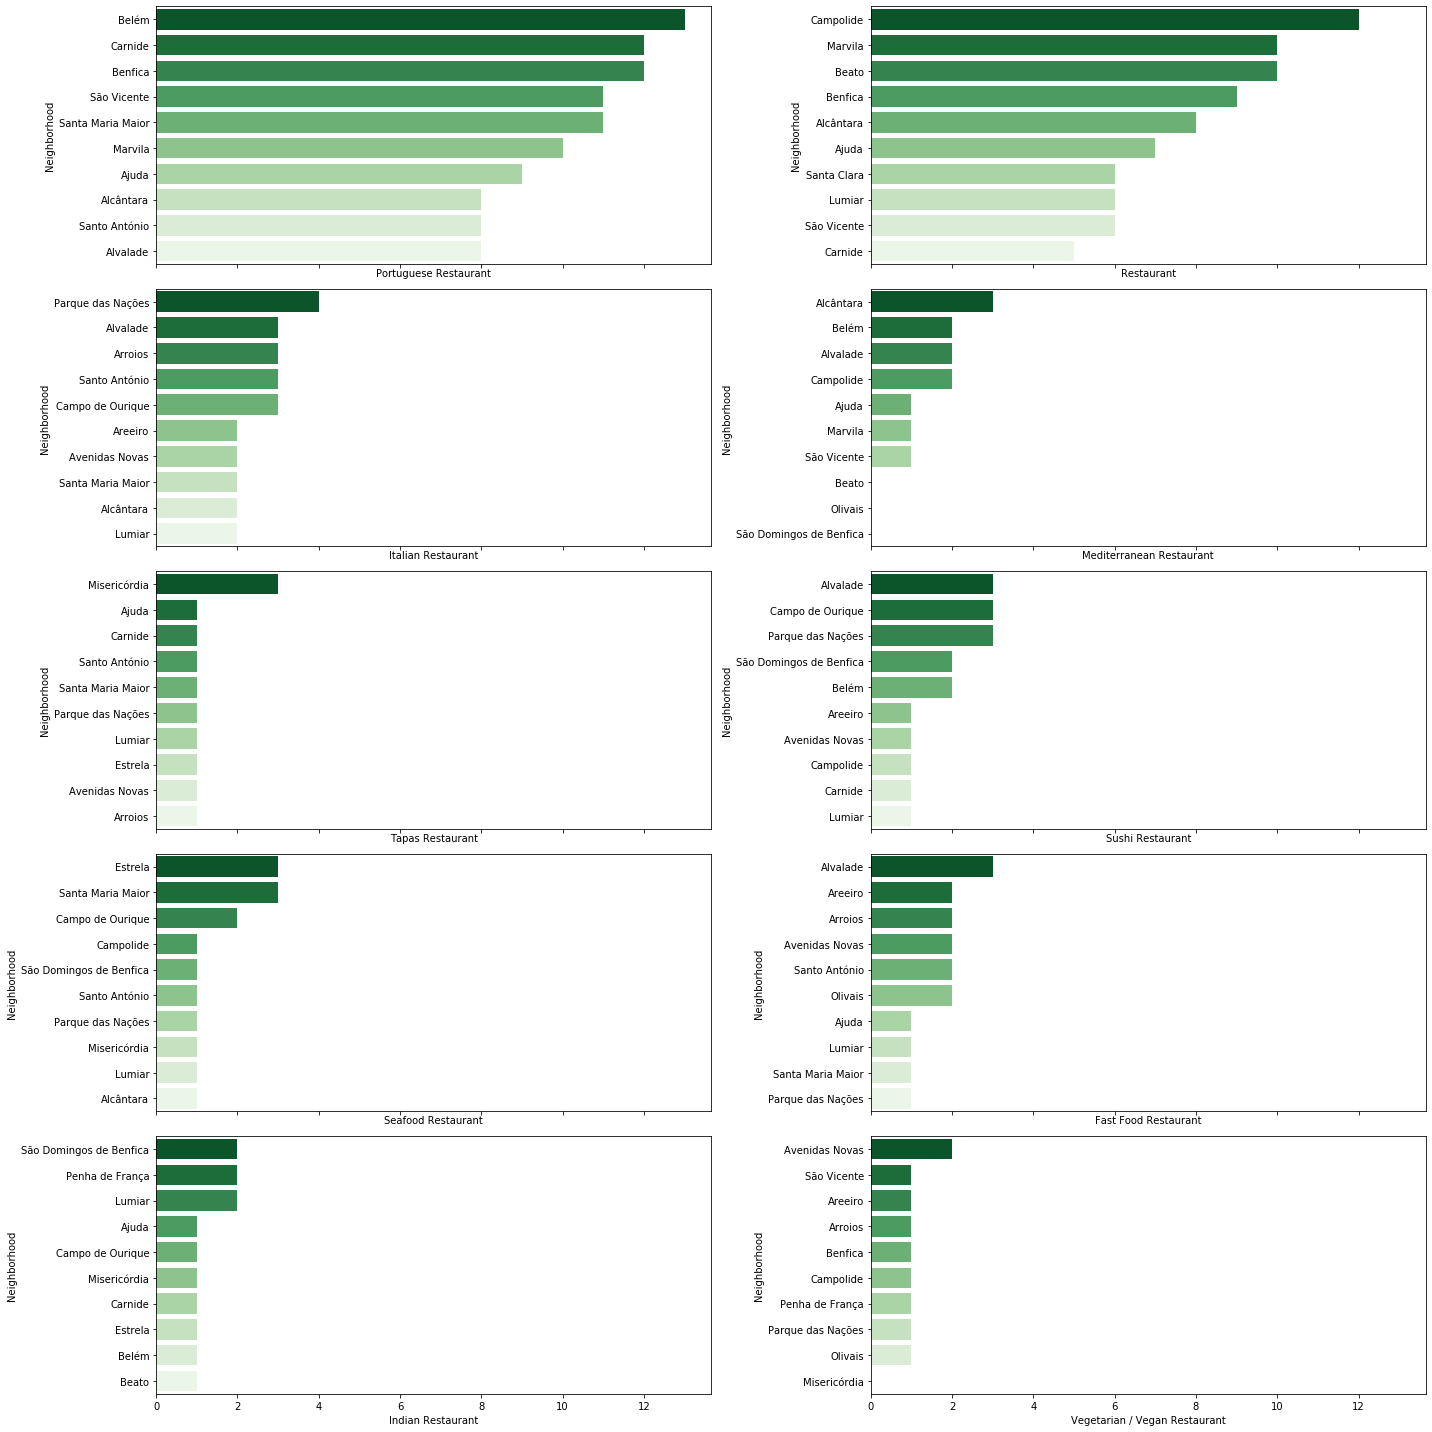

In [49]:
#!pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes =plt.subplots(5, 2, figsize=(20,20), sharex=True)
axes = axes.flatten()

for ax, category in zip(axes, restaurant_top10_list):
    data = restaurants_counts[[category]].sort_values([category], ascending=False)[0:10]
    pal = sns.color_palette("Greens", len(data))
    sns.barplot(x=category, y=data.index, data=data, ax=ax, palette=np.array(pal[::-1]))

plt.tight_layout()
plt.show();

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [31]:
lisbon_restaurants_grouped = lisbon_restaurants_onehot.groupby('Neighborhood').mean().reset_index()
lisbon_restaurants_grouped.head()

,Neighborhood,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Brazilian Restaurant,Cantonese Restaurant,Chinese Restaurant,Comfort Food Restaurant,Dim Sum Restaurant,Fast Food Restaurant,Gluten-free Restaurant,Himalayan Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Lebanese Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Persian Restaurant,Peruvian Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,Spanish Restaurant,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Ajuda,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.043478,0.043478,0.0,0.043478,0.000000,0.0,0.043478,0.000000,0.000000,0.0,0.0,0.043478,0.000000,0.000000,0.000000,0.000000,0.0,0.391304,0.000000,0.304348,0.043478,0.000000,0.000000,0.043478,0.000000,0.0,0.000000,0.0
1,Alcântara,0.000000,0.0,0.0,0.000000,0.035714,0.0,0.000000,0.000000,0.0,0.035714,0.035714,0.0,0.000000,0.071429,0.000000,0.0,0.0,0.107143,0.035714,0.000000,0.035714,0.000000,0.0,0.285714,0.000000,0.285714,0.035714,0.035714,0.000000,0.000000,0.000000,0.0,0.000000,0.0
2,Alvalade,0.000000,0.0,0.0,0.033333,0.033333,0.0,0.066667,0.000000,0.0,0.100000,0.000000,0.0,0.000000,0.100000,0.033333,0.0,0.0,0.066667,0.000000,0.000000,0.000000,0.033333,0.0,0.266667,0.000000,0.100000,0.000000,0.000000,0.100000,0.033333,0.033333,0.0,0.000000,0.0
3,Areeiro,0.043478,0.0,0.0,0.043478,0.086957,0.0,0.086957,0.000000,0.0,0.086957,0.000000,0.0,0.000000,0.086957,0.000000,0.0,0.0,0.000000,0.000000,0.043478,0.000000,0.043478,0.0,0.260870,0.000000,0.086957,0.000000,0.000000,0.043478,0.043478,0.000000,0.0,0.043478,0.0
4,Arroios,0.000000,0.0,0.0,0.045455,0.000000,0.0,0.090909,0.000000,0.0,0.090909,0.000000,0.0,0.045455,0.136364,0.045455,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.272727,0.045455,0.045455,0.045455,0.000000,0.000000,0.045455,0.045455,0.0,0.045455,0.0


#### Let's write a function to sort the venues in descending order.

In [32]:
def return_most_common_restaurants(row, num_top_restaurants):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_restaurants]

In [33]:
num_top_restaurants = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top restaurants
columns = ['Neighborhood']
for ind in np.arange(num_top_restaurants):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))    

In [34]:
# create a new dataframe
neighborhoods_restaurants_sorted = pd.DataFrame(columns=columns)
neighborhoods_restaurants_sorted['Neighborhood'] = lisbon_restaurants_grouped['Neighborhood']

In [35]:
for ind in np.arange(lisbon_restaurants_grouped.shape[0]):
    neighborhoods_restaurants_sorted.iloc[ind, 1:] = return_most_common_restaurants(lisbon_restaurants_grouped.iloc[ind, :], num_top_restaurants)

neighborhoods_restaurants_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Ajuda,Portuguese Restaurant,Restaurant,Indian Restaurant,Comfort Food Restaurant,Mediterranean Restaurant
1,Alcântara,Portuguese Restaurant,Restaurant,Mediterranean Restaurant,Italian Restaurant,Mexican Restaurant
2,Alvalade,Portuguese Restaurant,Sushi Restaurant,Fast Food Restaurant,Restaurant,Italian Restaurant
3,Areeiro,Portuguese Restaurant,Brazilian Restaurant,Fast Food Restaurant,Chinese Restaurant,Restaurant
4,Arroios,Portuguese Restaurant,Italian Restaurant,Chinese Restaurant,Fast Food Restaurant,Indian Restaurant
5,Avenidas Novas,Portuguese Restaurant,Restaurant,Vegetarian / Vegan Restaurant,Fast Food Restaurant,Italian Restaurant
6,Beato,Restaurant,Portuguese Restaurant,Argentinian Restaurant,Indian Restaurant,Cantonese Restaurant
7,Belém,Portuguese Restaurant,Restaurant,Mediterranean Restaurant,Sushi Restaurant,Indian Restaurant
8,Benfica,Portuguese Restaurant,Restaurant,Comfort Food Restaurant,Vegetarian / Vegan Restaurant,Asian Restaurant
9,Campo de Ourique,Portuguese Restaurant,Restaurant,Italian Restaurant,Sushi Restaurant,Seafood Restaurant


### Clustering Neighborhoods

In [36]:
lisbon_restaurants_grouped = lisbon_restaurants_grouped.drop('Neighborhood', 1)

The **Silhouette** method is preferable compared to the Elbow method (which is not so reliable) because it is more precise.

In [37]:
from sklearn.metrics import silhouette_score

sil = []
K_sil = range(2,24)
for k in K_sil:
    kmeans = KMeans(n_clusters = k).fit(lisbon_restaurants_grouped)
    labels = kmeans.labels_
    sil.append(silhouette_score(lisbon_restaurants_grouped, labels, metric = 'euclidean'))

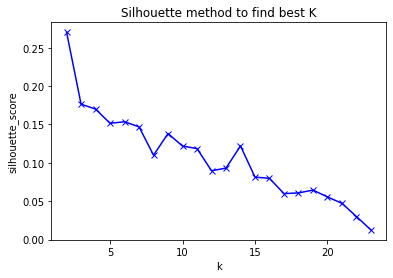

In [38]:
plt.plot(K_sil, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette_score')
plt.title('Silhouette method to find best K')
plt.show()

#### K=5 seems to be a good value for our K-means algorithm

In [39]:
kclusters = 5

# k-means clustering
kmeans = KMeans(init="k-means++", n_clusters=kclusters).fit(lisbon_restaurants_grouped)

In [40]:
# add clustering labels
neighborhoods_restaurants_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

lisbon_merged = df

# merge previous df with lisbon to add latitude/longitude for each neighborhood
lisbon_merged = lisbon_merged.join(neighborhoods_restaurants_sorted.set_index('Neighborhood'), on='Neighbourhood')

lisbon_merged.head(50) # check the last columns!

,Neighbourhood,Population,Area,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Ajuda,15 617,288,38.712327,-9.201241,2,Portuguese Restaurant,Restaurant,Indian Restaurant,Comfort Food Restaurant,Mediterranean Restaurant
1,Alcântara,13 943,"5,07",38.711057,-9.182876,0,Portuguese Restaurant,Restaurant,Mediterranean Restaurant,Italian Restaurant,Mexican Restaurant
2,Alvalade,31 813,534,38.753341,-9.149140,1,Portuguese Restaurant,Sushi Restaurant,Fast Food Restaurant,Restaurant,Italian Restaurant
5,Areeiro,20 131,174,38.742379,-9.133396,1,Portuguese Restaurant,Brazilian Restaurant,Fast Food Restaurant,Chinese Restaurant,Restaurant
7,Arroios,31 653,213,38.731932,-9.134246,3,Portuguese Restaurant,Italian Restaurant,Chinese Restaurant,Fast Food Restaurant,Indian Restaurant
10,Avenidas Novas,21 625,299,38.736436,-9.149825,1,Portuguese Restaurant,Restaurant,Vegetarian / Vegan Restaurant,Fast Food Restaurant,Italian Restaurant
12,Beato,12 737,"2,46",38.732622,-9.110240,4,Restaurant,Portuguese Restaurant,Argentinian Restaurant,Indian Restaurant,Cantonese Restaurant
14,Belém,16 528,"10,43",38.697769,-9.209432,2,Portuguese Restaurant,Restaurant,Mediterranean Restaurant,Sushi Restaurant,Indian Restaurant
15,Benfica,36 985,803,38.738027,-9.195299,2,Portuguese Restaurant,Restaurant,Comfort Food Restaurant,Vegetarian / Vegan Restaurant,Asian Restaurant
16,Campo de Ourique,22 120,165,38.718213,-9.165223,1,Portuguese Restaurant,Restaurant,Italian Restaurant,Sushi Restaurant,Seafood Restaurant


In [41]:
# drop NaN values
lisbon_merged = lisbon_merged.dropna()
lisbon_merged.head(10) # check the last columns!

,Neighbourhood,Population,Area,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Ajuda,15 617,288,38.712327,-9.201241,2,Portuguese Restaurant,Restaurant,Indian Restaurant,Comfort Food Restaurant,Mediterranean Restaurant
1,Alcântara,13 943,"5,07",38.711057,-9.182876,0,Portuguese Restaurant,Restaurant,Mediterranean Restaurant,Italian Restaurant,Mexican Restaurant
2,Alvalade,31 813,534,38.753341,-9.149140,1,Portuguese Restaurant,Sushi Restaurant,Fast Food Restaurant,Restaurant,Italian Restaurant
5,Areeiro,20 131,174,38.742379,-9.133396,1,Portuguese Restaurant,Brazilian Restaurant,Fast Food Restaurant,Chinese Restaurant,Restaurant
7,Arroios,31 653,213,38.731932,-9.134246,3,Portuguese Restaurant,Italian Restaurant,Chinese Restaurant,Fast Food Restaurant,Indian Restaurant
10,Avenidas Novas,21 625,299,38.736436,-9.149825,1,Portuguese Restaurant,Restaurant,Vegetarian / Vegan Restaurant,Fast Food Restaurant,Italian Restaurant
12,Beato,12 737,"2,46",38.732622,-9.110240,4,Restaurant,Portuguese Restaurant,Argentinian Restaurant,Indian Restaurant,Cantonese Restaurant
14,Belém,16 528,"10,43",38.697769,-9.209432,2,Portuguese Restaurant,Restaurant,Mediterranean Restaurant,Sushi Restaurant,Indian Restaurant
15,Benfica,36 985,803,38.738027,-9.195299,2,Portuguese Restaurant,Restaurant,Comfort Food Restaurant,Vegetarian / Vegan Restaurant,Asian Restaurant
16,Campo de Ourique,22 120,165,38.718213,-9.165223,1,Portuguese Restaurant,Restaurant,Italian Restaurant,Sushi Restaurant,Seafood Restaurant


In [42]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(lisbon_merged['Latitude'], lisbon_merged['Longitude'], lisbon_merged['Neighbourhood'], lisbon_merged['Cluster Labels']):
    cluster = int(cluster)
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examine Clusters

#### Cluster 1

In [50]:
lisbon_merged.loc[lisbon_merged['Cluster Labels'] == 0, lisbon_merged.columns[[1] + list(range(5, lisbon_merged.shape[1]))]]

,Population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,13 943,0,Portuguese Restaurant,Restaurant,Mediterranean Restaurant,Italian Restaurant,Mexican Restaurant
18,15 460,0,Restaurant,Portuguese Restaurant,Japanese Restaurant,Mediterranean Restaurant,Korean Restaurant
23,45 605,0,Restaurant,Portuguese Restaurant,Indian Restaurant,Italian Restaurant,Seafood Restaurant


#### Cluster 2

In [51]:
lisbon_merged.loc[lisbon_merged['Cluster Labels'] == 1, lisbon_merged.columns[[1] + list(range(5, lisbon_merged.shape[1]))]]

,Population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
2,31 813,1,Portuguese Restaurant,Sushi Restaurant,Fast Food Restaurant,Restaurant,Italian Restaurant
5,20 131,1,Portuguese Restaurant,Brazilian Restaurant,Fast Food Restaurant,Chinese Restaurant,Restaurant
10,21 625,1,Portuguese Restaurant,Restaurant,Vegetarian / Vegan Restaurant,Fast Food Restaurant,Italian Restaurant
16,22 120,1,Portuguese Restaurant,Restaurant,Italian Restaurant,Sushi Restaurant,Seafood Restaurant
29,33 788,1,Portuguese Restaurant,Fast Food Restaurant,Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant
30,21 025,1,Portuguese Restaurant,Italian Restaurant,Sushi Restaurant,Restaurant,Tapas Restaurant
31,27 967,1,Portuguese Restaurant,Restaurant,Italian Restaurant,Chinese Restaurant,Indian Restaurant
50,33 043,1,Portuguese Restaurant,Restaurant,Indian Restaurant,Sushi Restaurant,Japanese Restaurant


#### Cluster 3

In [52]:
lisbon_merged.loc[lisbon_merged['Cluster Labels'] == 2, lisbon_merged.columns[[1] + list(range(5, lisbon_merged.shape[1]))]]

,Population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,15 617,2,Portuguese Restaurant,Restaurant,Indian Restaurant,Comfort Food Restaurant,Mediterranean Restaurant
14,16 528,2,Portuguese Restaurant,Restaurant,Mediterranean Restaurant,Sushi Restaurant,Indian Restaurant
15,36 985,2,Portuguese Restaurant,Restaurant,Comfort Food Restaurant,Vegetarian / Vegan Restaurant,Asian Restaurant
19,19 218,2,Portuguese Restaurant,Restaurant,Fast Food Restaurant,Indian Restaurant,Tapas Restaurant
24,37 793,2,Restaurant,Portuguese Restaurant,Comfort Food Restaurant,Fast Food Restaurant,Mediterranean Restaurant
51,15 339,2,Portuguese Restaurant,Restaurant,Vietnamese Restaurant,Seafood Restaurant,Chinese Restaurant


#### Cluster 4

In [53]:
lisbon_merged.loc[lisbon_merged['Cluster Labels'] == 3, lisbon_merged.columns[[1] + list(range(5, lisbon_merged.shape[1]))]]

,Population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
7,31 653,3,Portuguese Restaurant,Italian Restaurant,Chinese Restaurant,Fast Food Restaurant,Indian Restaurant
20,20 128,3,Portuguese Restaurant,Seafood Restaurant,Restaurant,Mexican Restaurant,Middle Eastern Restaurant
28,13 044,3,Portuguese Restaurant,Tapas Restaurant,Italian Restaurant,African Restaurant,Asian Restaurant
46,12 822,3,Portuguese Restaurant,Seafood Restaurant,African Restaurant,Italian Restaurant,Restaurant
47,11 836,3,Portuguese Restaurant,Italian Restaurant,Restaurant,Fast Food Restaurant,Himalayan Restaurant


#### Cluster 5

In [54]:
lisbon_merged.loc[lisbon_merged['Cluster Labels'] == 4, lisbon_merged.columns[[1] + list(range(5, lisbon_merged.shape[1]))]]

,Population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
12,12 737,4,Restaurant,Portuguese Restaurant,Argentinian Restaurant,Indian Restaurant,Cantonese Restaurant
33,22 480,4,Restaurant,Portuguese Restaurant,African Restaurant,Brazilian Restaurant,Italian Restaurant


#### @author _Gustavo Bakker_